In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn.downtoearth.org.in/library/large/2020-03-01/0.01792700_1583044755_coronavirus-illustration-carousel.jpg")

# COVID-19 Global Outlook: Prediction

Coronavirus disease 2019 (COVID-19) is an infectious disease caused by severe acute respiratory syndrome. The first disease was identified in Dicember 2019 in Wuhan. On March 11 2020, after 118,000 people being infected in 114 Countries, and causing the death of 4,291 people, COVID-19 has been recognized as a pandemic. Today, April 13,2020, the pandemic infected 1,854,464 people in 185 countries, causing the death of 114,331 people.

In the context of the global COVID-19 pandemic, we follow the suggestions from Kaggle's competitions in order to provide useful insights about the virus' spread. Starting from a global exploratory analysis, then we focus on virus' modelling and prediction for the countries with the largest number of confirmed cases. For modelling, we implement SIR Model with some extensions and, for prediction, logistic and Gompertz model. At the end, we choose the best model based on $R^{2}$ score, check the predictions' numbers about confirmed and fatalities for the next time interval and display some results from NLTK Sentiment analysis. 

Data: [COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-4) 

**TABLE OF CONTENTS**

3. [Prediction](#section3)

    3.1. [Logistic model](#section31)
    
    3.2. [Gompertz model](#section32)
    
    3.3. [Results](#section33)
    
    

# **3. Prediction** <a id="section3"></a>

Firstly, we define the model function for fit and plotting. We decide to fit the model only to some selected countries because it's difficult to initialize the fit parameters correctly for countries with few confirmed cases and fatalities or states with zero or much less statistics, since the results for some of them can be ambiguous.

The regression coefficient ($R^{2}$) is used to evaluate the fitting ability of various methods and can be obtained by the following equation.


$$ {R^{2}} = {1 - {\sum (y_{i}-\hat{y_{i}})^{2}} \over {\sum (y_{i}-\overline{y})^{2}}} $$


$y_{i}$ is the actual cumulative confirmed COVID-19 cases; $\hat{y_{i}}$ is the predicted cumulative confirmed COVID-19 cases; $\overline{y}$ is the average of the actual cumulative confirmed COVID-19 cases. The closer the fitting coefficient is to 1, the more accurate the prediction.

For simplicity's sake, we put the results at the end of the notebook.

IMPORTANT: the Logistic model takes into account the most affected provinces/states for China and US. 


## **3.1 Logistic model** <a id="section31"></a>

Logistic model is mainly used in epidemiology. It is commonly to explore the risk factors of a certain disease, and predict the probability of occurrence of a certain disease according to the risk factors. We can roughly predict the development and transmission law of epidemiology through logistic regression analysis.


$$ {𝑄_t} = {a \over 1 + e^{b-c(t−t_0)}}$$ 


$𝑄_t$ is the cumulative confirmed cases (deaths); $a$ is the predicted maximum of confirmed cases (deaths). $b$ and $c$ are fitting coefficients. $t$ is the number of days since the first case. $t_{0}$ is the time when the first case occurred.

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
api.competition_download_file('covid19-global-forecasting-week-4','train.csv')
api.competition_download_file('covid19-global-forecasting-week-4','test.csv')
api.competition_download_file('covid19-global-forecasting-week-4','submission.csv')

  0%|          | 0.00/988k [00:00<?, ?B/s]

100%|██████████| 988k/988k [00:00<00:00, 3.49MB/s]


100%|██████████| 388k/388k [00:00<00:00, 8.14MB/s]


100%|██████████| 121k/121k [00:00<00:00, 4.07MB/s]

In [4]:
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import scipy.optimize as opt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission_example = pd.read_csv("submission.csv")

In [6]:
train_ = train[train["ConfirmedCases"] >= 0]
train_.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


Replace all na (Province_State) with country:

In [7]:
EMPTY_VAL = "EMPTY_VAL"

def fillState(state, country):
    if state == EMPTY_VAL: return country
    return state

train_['Province_State'].fillna(EMPTY_VAL, inplace=True)
train_['Province_State'] = train_.loc[:, ['Province_State', 'Country_Region']].apply(lambda x : fillState(x['Province_State'], x['Country_Region']), axis=1)
test['Province_State'].fillna(EMPTY_VAL, inplace=True)
test['Province_State'] = test.loc[:, ['Province_State', 'Country_Region']].apply(lambda x : fillState(x['Province_State'], x['Country_Region']), axis=1)
test.head()

,ForecastId,Province_State,Country_Region,Date
0,1,Afghanistan,Afghanistan,2020-04-02
1,2,Afghanistan,Afghanistan,2020-04-03
2,3,Afghanistan,Afghanistan,2020-04-04
3,4,Afghanistan,Afghanistan,2020-04-05
4,5,Afghanistan,Afghanistan,2020-04-06


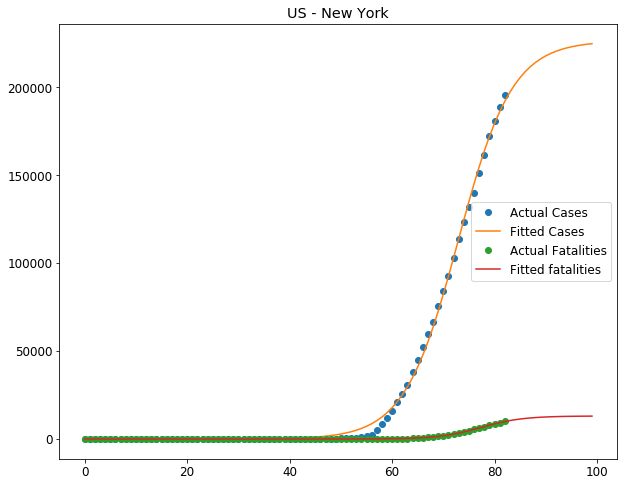

The R^2 for the Actual Cases is: 0.9981275741574477 

 The R^2 for the Fatalities is: 0.9995081228042362


In [25]:
train_['row_number'] = train_.groupby(['Country_Region', 'Province_State']).cumcount()
x = train_[train_["Country_Region"] == 'US'][train_["Province_State"] == 'New York']['row_number']
y = train_[train_["Country_Region"] == 'US'][train_["Province_State"] == 'New York']['ConfirmedCases']
y_ = train_[train_["Country_Region"] == 'US'][train_["Province_State"] == 'New York']['Fatalities']

def f(x, L, b, k, x_0):
    return L / (1. + np.exp(-k * (x - x_0))) + b


def logistic(xs, L, k, x_0):
    result = []
    for x in xs:
        xp = k*(x-x_0)
        if xp >= 0:
            result.append(L / ( 1. + np.exp(-xp) ) )
        else:
            result.append(L * np.exp(xp) / ( 1. + np.exp(xp) ) )
    return result

p0 = [max(y), 0.0,max(x)]
p0_ = [max(y_), 0.0,max(x)]
x_ = np.arange(0, 100, 1).tolist()
try:
    popt, pcov = opt.curve_fit(logistic, x, y,p0)
    yfit = logistic(x_, *popt)
    popt_, pcov_ = opt.curve_fit(logistic, x, y_,p0_)
    yfit_ = logistic(x_, *popt_)
except:
    popt, pcov = opt.curve_fit(f, x, y, method="lm", maxfev=5000)
    yfit = f(x_, *popt)
    popt_, pcov_ = opt.curve_fit(f, x, y_, method="lm", maxfev=5000)
    yfit_ = f(x_, *popt_)
    #print("problem")


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'o', label ='Actual Cases')
ax.plot(x_, yfit, '-', label ='Fitted Cases')

ax.plot(x, y_, 'o', label ='Actual Fatalities')
ax.plot(x_, yfit_, '-', label ='Fitted fatalities')
ax.title.set_text('US - New York')
plt.legend(loc="center right")
plt.show()

n_train_days =df_country_train.Date.nunique() 
correlation_matrix = np.corrcoef(y[1:81], yfit[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

correlation_matrix = np.corrcoef(y_[1:81], yfit_[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared1 = correlation_xy**2
r_squared1

print("The R^2 for the Actual Cases is:", r_squared,"\n\n The R^2 for the Fatalities is:",r_squared1)

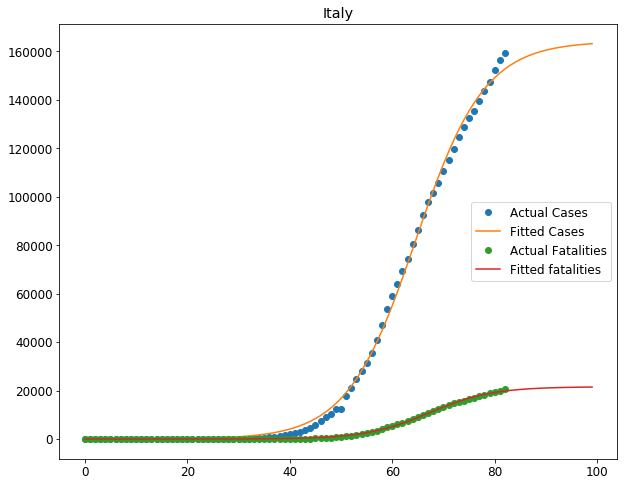

The R^2 for the Actual Cases is: 0.9987612230650231 

 The R^2 for the Fatalities is: 0.9992508088718337


In [31]:
train_['row_number'] = train_.groupby(['Country_Region', 'Province_State']).cumcount()
x = train_[train_["Country_Region"] == 'Italy'][train_["Province_State"] == 'Italy']['row_number']
y = train_[train_["Country_Region"] == 'Italy'][train_["Province_State"] == 'Italy']['ConfirmedCases']
y_ = train_[train_["Country_Region"] == 'Italy'][train_["Province_State"] == 'Italy']['Fatalities']

def f(x, L, b, k, x_0):
    return L / (1. + np.exp(-k * (x - x_0))) + b


def logistic(xs, L, k, x_0):
    result = []
    for x in xs:
        xp = k*(x-x_0)
        if xp >= 0:
            result.append(L / ( 1. + np.exp(-xp) ) )
        else:
            result.append(L * np.exp(xp) / ( 1. + np.exp(xp) ) )
    return result

p0 = [max(y), 0.0,max(x)]
p0_ = [max(y_), 0.0,max(x)]
x_ = np.arange(0, 100, 1).tolist()
try:
    popt, pcov = opt.curve_fit(logistic, x, y,p0)
    yfit = logistic(x_, *popt)
    popt_, pcov_ = opt.curve_fit(logistic, x, y_,p0_)
    yfit_ = logistic(x_, *popt_)
except:
    popt, pcov = opt.curve_fit(f, x, y, method="lm", maxfev=5000)
    yfit = f(x_, *popt)
    popt_, pcov_ = opt.curve_fit(f, x, y_, method="lm", maxfev=5000)
    yfit_ = f(x_, *popt_)
    #print("problem")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'o', label ='Actual Cases')
ax.plot(x_, yfit, '-', label ='Fitted Cases')

ax.plot(x, y_, 'o', label ='Actual Fatalities')
ax.plot(x_, yfit_, '-', label ='Fitted fatalities')
ax.title.set_text('Italy')
plt.legend(loc="center right")
plt.show()

correlation_matrix = np.corrcoef(y[1:81], yfit[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

correlation_matrix = np.corrcoef(y_[1:81], yfit_[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared1 = correlation_xy**2
r_squared1

print("The R^2 for the Actual Cases is:", r_squared,"\n\n The R^2 for the Fatalities is:",r_squared1)

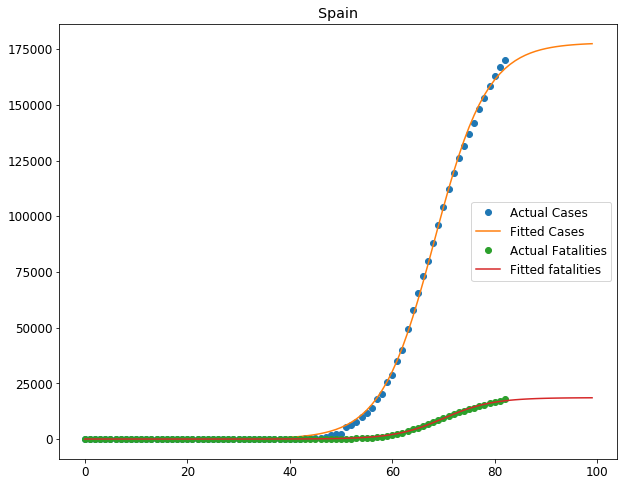

The R^2 for the Actual Cases is: 0.9994196464736643 

 The R^2 for the Fatalities is: 0.9989160119705337


In [32]:
train_['row_number'] = train_.groupby(['Country_Region', 'Province_State']).cumcount()
x = train_[train_["Country_Region"] == 'Spain'][train_["Province_State"] == 'Spain']['row_number']
y = train_[train_["Country_Region"] == 'Spain'][train_["Province_State"] == 'Spain']['ConfirmedCases']
y_ = train_[train_["Country_Region"] == 'Spain'][train_["Province_State"] == 'Spain']['Fatalities']

def f(x, L, b, k, x_0):
    return L / (1. + np.exp(-k * (x - x_0))) + b


def logistic(xs, L, k, x_0):
    result = []
    for x in xs:
        xp = k*(x-x_0)
        if xp >= 0:
            result.append(L / ( 1. + np.exp(-xp) ) )
        else:
            result.append(L * np.exp(xp) / ( 1. + np.exp(xp) ) )
    return result

p0 = [max(y), 0.0,max(x)]
p0_ = [max(y_), 0.0,max(x)]
x_ = np.arange(0, 100, 1).tolist()
try:
    popt, pcov = opt.curve_fit(logistic, x, y,p0)
    yfit = logistic(x_, *popt)
    popt_, pcov_ = opt.curve_fit(logistic, x, y_,p0_)
    yfit_ = logistic(x_, *popt_)
except:
    popt, pcov = opt.curve_fit(f, x, y, method="lm", maxfev=5000)
    yfit = f(x_, *popt)
    popt_, pcov_ = opt.curve_fit(f, x, y_, method="lm", maxfev=5000)
    yfit_ = f(x_, *popt_)
    #print("problem")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'o', label ='Actual Cases')
ax.plot(x_, yfit, '-', label ='Fitted Cases')

ax.plot(x, y_, 'o', label ='Actual Fatalities')
ax.plot(x_, yfit_, '-', label ='Fitted fatalities')
ax.title.set_text('Spain')
plt.legend(loc="center right")
plt.show()

correlation_matrix = np.corrcoef(y[1:81], yfit[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

correlation_matrix = np.corrcoef(y_[1:81], yfit_[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared1 = correlation_xy**2
r_squared1

print("The R^2 for the Actual Cases is:", r_squared,"\n\n The R^2 for the Fatalities is:",r_squared1)

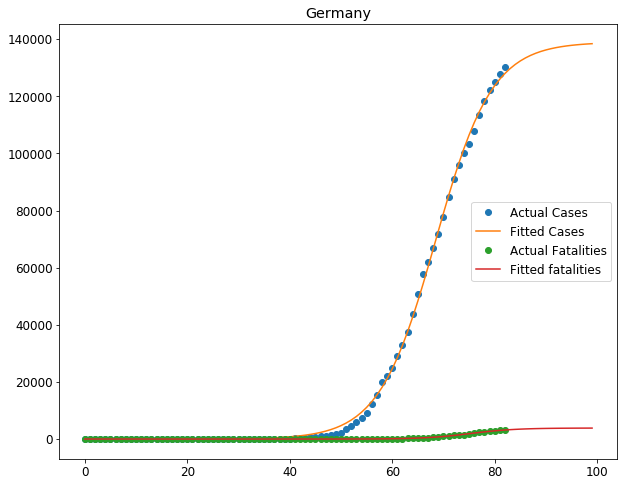

The R^2 for the Actual Cases is: 0.9991415091432515 

 The R^2 for the Fatalities is: 0.9984607100542066


In [33]:
train_['row_number'] = train_.groupby(['Country_Region', 'Province_State']).cumcount()
x = train_[train_["Country_Region"] == 'Germany'][train_["Province_State"] == 'Germany']['row_number']
y = train_[train_["Country_Region"] == 'Germany'][train_["Province_State"] == 'Germany']['ConfirmedCases']
y_ = train_[train_["Country_Region"] == 'Germany'][train_["Province_State"] == 'Germany']['Fatalities']

def f(x, L, b, k, x_0):
    return L / (1. + np.exp(-k * (x - x_0))) + b


def logistic(xs, L, k, x_0):
    result = []
    for x in xs:
        xp = k*(x-x_0)
        if xp >= 0:
            result.append(L / ( 1. + np.exp(-xp) ) )
        else:
            result.append(L * np.exp(xp) / ( 1. + np.exp(xp) ) )
    return result

p0 = [max(y), 0.0,max(x)]
p0_ = [max(y_), 0.0,max(x)]
x_ = np.arange(0, 100, 1).tolist()
try:
    popt, pcov = opt.curve_fit(logistic, x, y,p0)
    yfit = logistic(x_, *popt)
    popt_, pcov_ = opt.curve_fit(logistic, x, y_,p0_)
    yfit_ = logistic(x_, *popt_)
except:
    popt, pcov = opt.curve_fit(f, x, y, method="lm", maxfev=5000)
    yfit = f(x_, *popt)
    popt_, pcov_ = opt.curve_fit(f, x, y_, method="lm", maxfev=5000)
    yfit_ = f(x_, *popt_)
    #print("problem")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'o', label ='Actual Cases')
ax.plot(x_, yfit, '-', label ='Fitted Cases')

ax.plot(x, y_, 'o', label ='Actual Fatalities')
ax.plot(x_, yfit_, '-', label ='Fitted fatalities')
ax.title.set_text('Germany')
plt.legend(loc="center right")
plt.show()

correlation_matrix = np.corrcoef(y[1:81], yfit[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

correlation_matrix = np.corrcoef(y_[1:81], yfit_[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared1 = correlation_xy**2
r_squared1

print("The R^2 for the Actual Cases is:", r_squared,"\n\n The R^2 for the Fatalities is:",r_squared1)

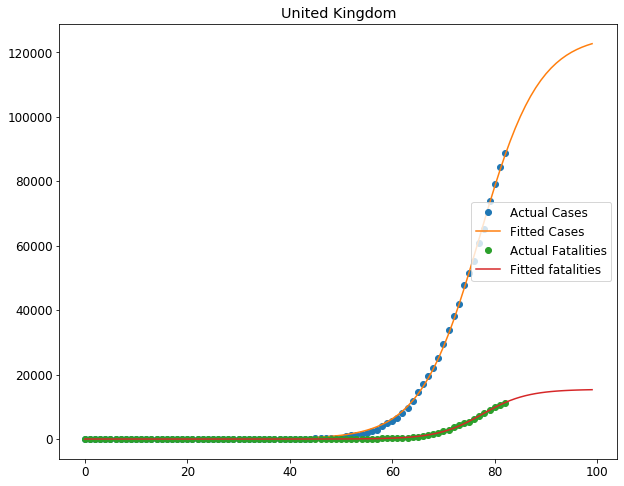

The R^2 for the Actual Cases is: 0.9990300610464611 

 The R^2 for the Fatalities is: 0.9990983662084553


In [34]:
train_['row_number'] = train_.groupby(['Country_Region', 'Province_State']).cumcount()
x = train_[train_["Country_Region"] == 'United Kingdom'][train_["Province_State"] == 'United Kingdom']['row_number']
y = train_[train_["Country_Region"] == 'United Kingdom'][train_["Province_State"] == 'United Kingdom']['ConfirmedCases']
y_ = train_[train_["Country_Region"] == 'United Kingdom'][train_["Province_State"] == 'United Kingdom']['Fatalities']

def f(x, L, b, k, x_0):
    return L / (1. + np.exp(-k * (x - x_0))) + b


def logistic(xs, L, k, x_0):
    result = []
    for x in xs:
        xp = k*(x-x_0)
        if xp >= 0:
            result.append(L / ( 1. + np.exp(-xp) ) )
        else:
            result.append(L * np.exp(xp) / ( 1. + np.exp(xp) ) )
    return result

p0 = [max(y), 0.0,max(x)]
p0_ = [max(y_), 0.0,max(x)]
x_ = np.arange(0, 100, 1).tolist()
try:
    popt, pcov = opt.curve_fit(logistic, x, y,p0)
    yfit = logistic(x_, *popt)
    popt_, pcov_ = opt.curve_fit(logistic, x, y_,p0_)
    yfit_ = logistic(x_, *popt_)
except:
    popt, pcov = opt.curve_fit(f, x, y, method="lm", maxfev=5000)
    yfit = f(x_, *popt)
    popt_, pcov_ = opt.curve_fit(f, x, y_, method="lm", maxfev=5000)
    yfit_ = f(x_, *popt_)
    #print("problem")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'o', label ='Actual Cases')
ax.plot(x_, yfit, '-', label ='Fitted Cases')

ax.plot(x, y_, 'o', label ='Actual Fatalities')
ax.plot(x_, yfit_, '-', label ='Fitted fatalities')
ax.title.set_text('United Kingdom')
plt.legend(loc="center right")
plt.show()

correlation_matrix = np.corrcoef(y[1:81], yfit[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

correlation_matrix = np.corrcoef(y_[1:81], yfit_[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared1 = correlation_xy**2
r_squared1

print("The R^2 for the Actual Cases is:", r_squared,"\n\n The R^2 for the Fatalities is:",r_squared1)

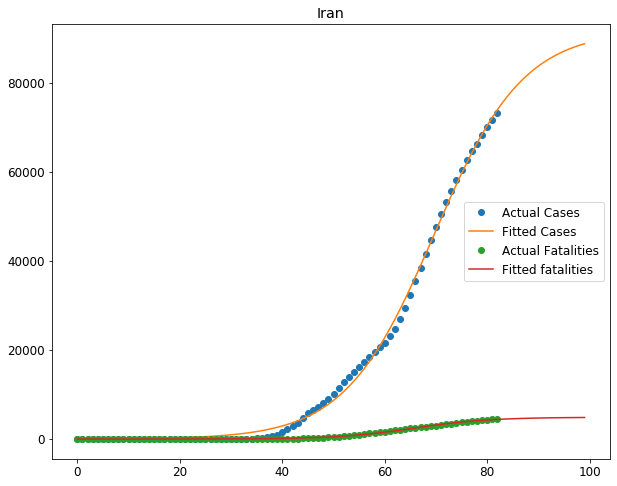

The R^2 for the Actual Cases is: 0.9977378240927349 

 The R^2 for the Fatalities is: 0.9975342104387871


In [35]:
train_['row_number'] = train_.groupby(['Country_Region', 'Province_State']).cumcount()
x = train_[train_["Country_Region"] == 'Iran'][train_["Province_State"] == 'Iran']['row_number']
y = train_[train_["Country_Region"] == 'Iran'][train_["Province_State"] == 'Iran']['ConfirmedCases']
y_ = train_[train_["Country_Region"] == 'Iran'][train_["Province_State"] == 'Iran']['Fatalities']

def f(x, L, b, k, x_0):
    return L / (1. + np.exp(-k * (x - x_0))) + b


def logistic(xs, L, k, x_0):
    result = []
    for x in xs:
        xp = k*(x-x_0)
        if xp >= 0:
            result.append(L / ( 1. + np.exp(-xp) ) )
        else:
            result.append(L * np.exp(xp) / ( 1. + np.exp(xp) ) )
    return result

p0 = [max(y), 0.0,max(x)]
p0_ = [max(y_), 0.0,max(x)]
x_ = np.arange(0, 100, 1).tolist()
try:
    popt, pcov = opt.curve_fit(logistic, x, y,p0)
    yfit = logistic(x_, *popt)
    popt_, pcov_ = opt.curve_fit(logistic, x, y_,p0_)
    yfit_ = logistic(x_, *popt_)
except:
    popt, pcov = opt.curve_fit(f, x, y, method="lm", maxfev=5000)
    yfit = f(x_, *popt)
    popt_, pcov_ = opt.curve_fit(f, x, y_, method="lm", maxfev=5000)
    yfit_ = f(x_, *popt_)
    #print("problem")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'o', label ='Actual Cases')
ax.plot(x_, yfit, '-', label ='Fitted Cases')

ax.plot(x, y_, 'o', label ='Actual Fatalities')
ax.plot(x_, yfit_, '-', label ='Fitted fatalities')
ax.title.set_text('Iran')
plt.legend(loc="center right")
plt.show()

correlation_matrix = np.corrcoef(y[1:81], yfit[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

correlation_matrix = np.corrcoef(y_[1:81], yfit_[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared1 = correlation_xy**2
r_squared1

print("The R^2 for the Actual Cases is:", r_squared,"\n\n The R^2 for the Fatalities is:",r_squared1)

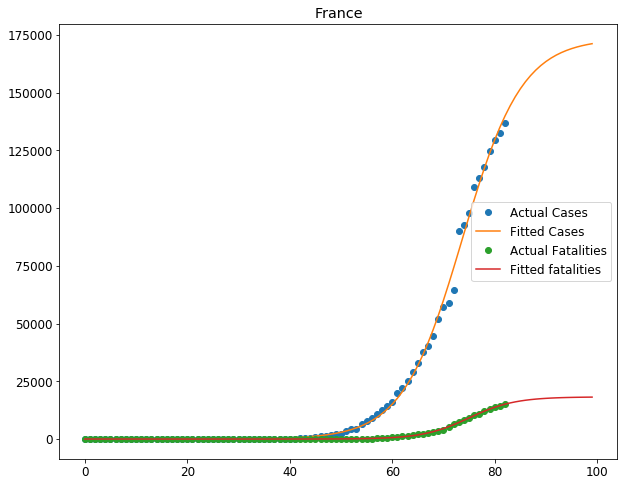

The R^2 for the Actual Cases is: 0.996480838125475 

 The R^2 for the Fatalities is: 0.9988071483772091


In [36]:
train_['row_number'] = train_.groupby(['Country_Region', 'Province_State']).cumcount()
x = train_[train_["Country_Region"] == 'France'][train_["Province_State"] == 'France']['row_number']
y = train_[train_["Country_Region"] == 'France'][train_["Province_State"] == 'France']['ConfirmedCases']
y_ = train_[train_["Country_Region"] == 'France'][train_["Province_State"] == 'France']['Fatalities']

def f(x, L, b, k, x_0):
    return L / (1. + np.exp(-k * (x - x_0))) + b


def logistic(xs, L, k, x_0):
    result = []
    for x in xs:
        xp = k*(x-x_0)
        if xp >= 0:
            result.append(L / ( 1. + np.exp(-xp) ) )
        else:
            result.append(L * np.exp(xp) / ( 1. + np.exp(xp) ) )
    return result

p0 = [max(y), 0.0,max(x)]
p0_ = [max(y_), 0.0,max(x)]
x_ = np.arange(0, 100, 1).tolist()
try:
    popt, pcov = opt.curve_fit(logistic, x, y,p0)
    yfit = logistic(x_, *popt)
    popt_, pcov_ = opt.curve_fit(logistic, x, y_,p0_)
    yfit_ = logistic(x_, *popt_)
except:
    popt, pcov = opt.curve_fit(f, x, y, method="lm", maxfev=5000)
    yfit = f(x_, *popt)
    popt_, pcov_ = opt.curve_fit(f, x, y_, method="lm", maxfev=5000)
    yfit_ = f(x_, *popt_)
    #print("problem")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'o', label ='Actual Cases')
ax.plot(x_, yfit, '-', label ='Fitted Cases')

ax.plot(x, y_, 'o', label ='Actual Fatalities')
ax.plot(x_, yfit_, '-', label ='Fitted fatalities')
ax.title.set_text('France')
plt.legend(loc="center right")
plt.show()

correlation_matrix = np.corrcoef(y[1:81], yfit[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

correlation_matrix = np.corrcoef(y_[1:81], yfit_[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared1 = correlation_xy**2
r_squared1

print("The R^2 for the Actual Cases is:", r_squared,"\n\n The R^2 for the Fatalities is:",r_squared1)

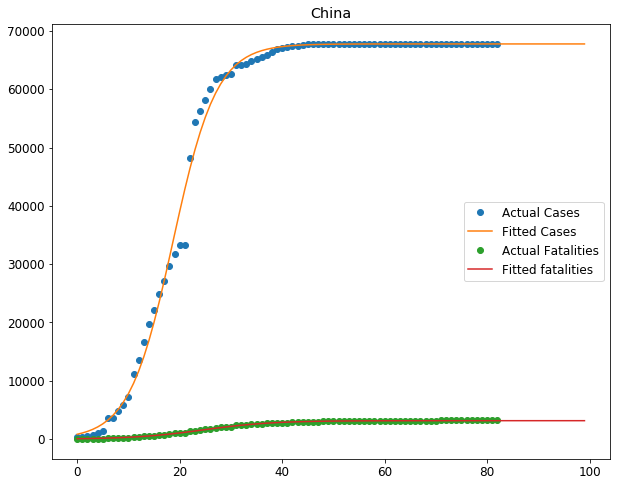

The R^2 for the Actual Cases is: 0.9948324007342542 

 The R^2 for the Fatalities is: 0.9983536368238739


In [37]:
train_['row_number'] = train_.groupby(['Country_Region', 'Province_State']).cumcount()
x = train_[train_["Country_Region"] == 'China'][train_["Province_State"] == 'Hubei']['row_number']
y = train_[train_["Country_Region"] == 'China'][train_["Province_State"] == 'Hubei']['ConfirmedCases']
y_ = train_[train_["Country_Region"] == 'China'][train_["Province_State"] == 'Hubei']['Fatalities']

def f(x, L, b, k, x_0):
    return L / (1. + np.exp(-k * (x - x_0))) + b


def logistic(xs, L, k, x_0):
    result = []
    for x in xs:
        xp = k*(x-x_0)
        if xp >= 0:
            result.append(L / ( 1. + np.exp(-xp) ) )
        else:
            result.append(L * np.exp(xp) / ( 1. + np.exp(xp) ) )
    return result

p0 = [max(y), 0.0,max(x)]
p0_ = [max(y_), 0.0,max(x)]
x_ = np.arange(0, 100, 1).tolist()
try:
    popt, pcov = opt.curve_fit(logistic, x, y,p0)
    yfit = logistic(x_, *popt)
    popt_, pcov_ = opt.curve_fit(logistic, x, y_,p0_)
    yfit_ = logistic(x_, *popt_)
except:
    popt, pcov = opt.curve_fit(f, x, y, method="lm", maxfev=5000)
    yfit = f(x_, *popt)
    popt_, pcov_ = opt.curve_fit(f, x, y_, method="lm", maxfev=5000)
    yfit_ = f(x_, *popt_)
    #print("problem")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'o', label ='Actual Cases')
ax.plot(x_, yfit, '-', label ='Fitted Cases')

ax.plot(x, y_, 'o', label ='Actual Fatalities')
ax.plot(x_, yfit_, '-', label ='Fitted fatalities')
ax.title.set_text('China')
plt.legend(loc="center right")
plt.show()

correlation_matrix = np.corrcoef(y[1:81], yfit[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

correlation_matrix = np.corrcoef(y_[1:81], yfit_[1:81])
correlation_xy = correlation_matrix[0,1]
r_squared1 = correlation_xy**2
r_squared1

print("The R^2 for the Actual Cases is:", r_squared,"\n\n The R^2 for the Fatalities is:",r_squared1)

## **3.2. Gompertz model** <a id="section32"></a>

The model was originally proposed by Gomperts (Gompertz,1825) as an animal population growth model to describe the extinction law of the population. The development of infectious diseases is similar to the growth of individuals and populations. In this paper, Gompertz model is selected to describe the spread law of infectious diseases and to study the factors that control and affect the spread of COVID- 19.

$${𝑄_t} = {ae^{−be^{-c(t−t_0)}}}$$ 

$𝑄_t$ is the cumulative confirmed cases (deaths); $a$ is the predicted maximum of confirmed cases (deaths), $b$ and $c$ are fitting coefficients; $t$ is the number of days since the first case. $t_{0}$ is the time when the first case occurred.

In [14]:
from itertools import cycle, islice
import seaborn as sb
import matplotlib.dates as dates
import datetime as dt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from itertools import cycle, islice

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly import tools, subplots
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

from scipy.optimize.minpack import curve_fit
from sklearn.metrics import r2_score
from scipy.special import expit

In [15]:
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

In [16]:
train_data['NewConfirmedCases'] = train_data['ConfirmedCases'] - train_data['ConfirmedCases'].shift(1)
train_data['NewConfirmedCases'] = train_data['NewConfirmedCases'].fillna(0.0)
train_data['NewFatalities']     = train_data['Fatalities'] - train_data['Fatalities'].shift(1)
train_data['NewFatalities']     = train_data['NewFatalities'].fillna(0.0)#.astype(int)

train_data.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,NewConfirmedCases,NewFatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,0.0,0.0


In [17]:
def getColumnInfo(df):
    n_province =  df['Province_State'].nunique()
    n_country  =  df['Country_Region'].nunique()
    n_days     =  df['Date'].nunique()
    start_date =  df['Date'].unique()[0]
    end_date   =  df['Date'].unique()[-1]
    return n_province, n_country, n_days, start_date, end_date

n_train = train_data.shape[0]
n_test = test_data.shape[0]

n_prov_train, n_count_train, n_train_days, start_date_train, end_date_train = getColumnInfo(train_data)
n_prov_test,  n_count_test,  n_test_days,  start_date_test,  end_date_test  = getColumnInfo(test_data)
df_test = test_data.loc[test_data.Date > '2020-04-03']
overlap_days = n_test_days - df_test.Date.nunique()

prob_confirm_check_train = train_data.ConfirmedCases.value_counts(normalize=True)
prob_fatal_check_train = train_data.Fatalities.value_counts(normalize=True)

n_confirm_train = train_data.ConfirmedCases.value_counts()[1:].sum()
n_fatal_train = train_data.Fatalities.value_counts()[1:].sum()

,Date,ConfirmedCases,Fatalities
Country_Region,,,
US,2020-04-13,682456.0,23527.0
Spain,2020-04-13,170099.0,17756.0
Italy,2020-04-13,159516.0,20465.0
France,2020-04-13,137875.0,14986.0
Germany,2020-04-13,130072.0,3194.0


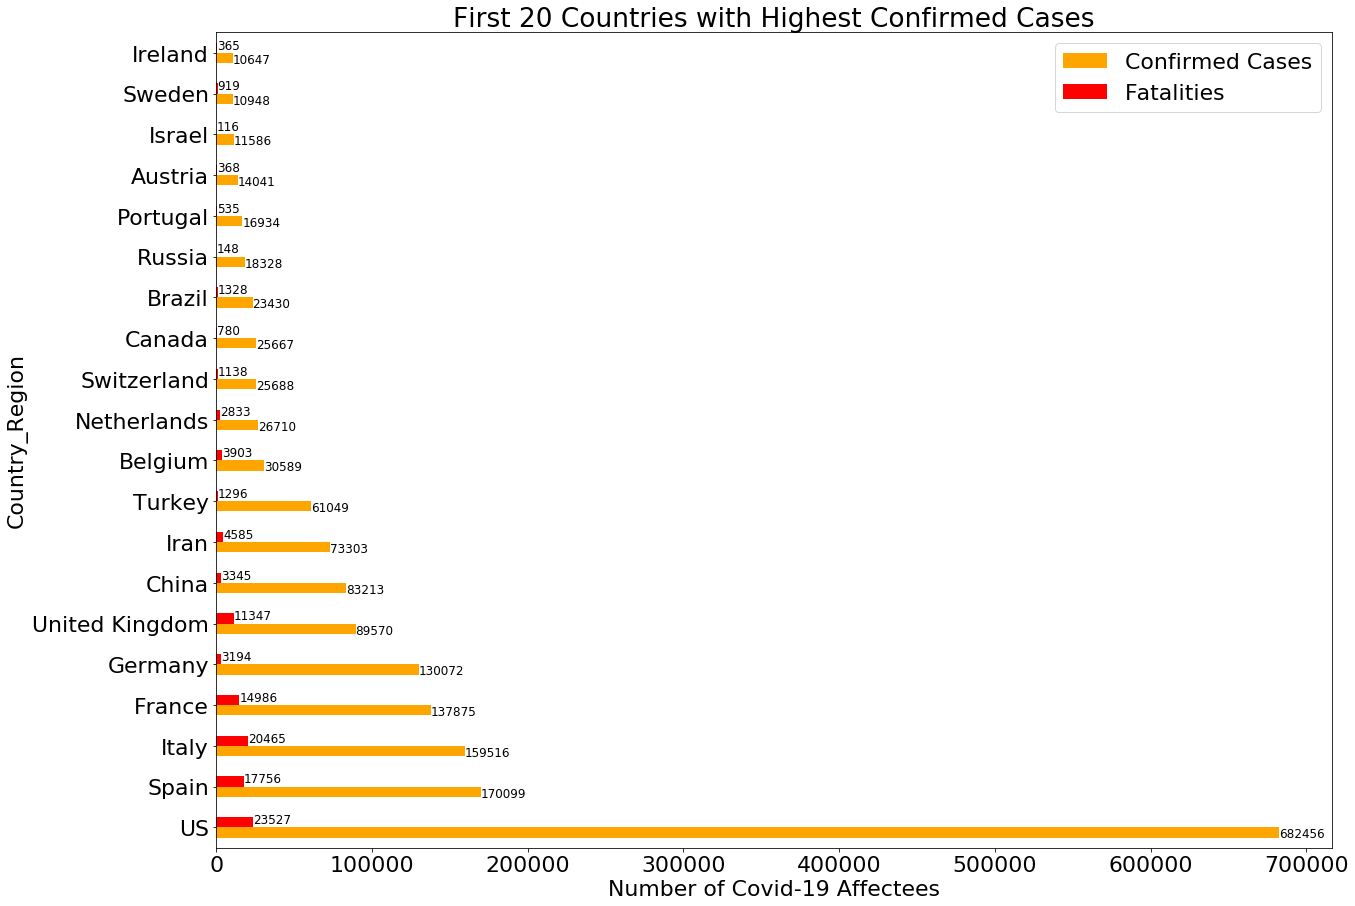

In [18]:
#train_data_by_country = train_data.groupby(['Country_Region'],as_index=True).agg({'ConfirmedCases': 'max', 'Fatalities': 'max'})
#train_data_by_country_confirm = train_data_by_country.sort_values(by=["ConfirmedCases"], ascending=False)
train_data_by_country = train_data.groupby(['Date','Country_Region'],as_index=False).agg({'ConfirmedCases': 'sum', 'Fatalities': 'sum'
                                                                                         })
                                                       #'GrowthRate':'mean'
max_train_date = train_data['Date'].max()
train_data_by_country_confirm = train_data_by_country.query('(Date == @max_train_date) & (ConfirmedCases > 100)').sort_values('ConfirmedCases', ascending=False)
train_data_by_country_confirm.set_index('Country_Region', inplace=True)
display(train_data_by_country_confirm.head())

from itertools import cycle, islice
discrete_col = list(islice(cycle(['orange', 'r', 'g', 'k', 'b', 'c', 'm']), None, len(train_data_by_country_confirm.head(30))))
plt.rcParams.update({'font.size': 22})
train_data_by_country_confirm.head(20).plot(figsize=(20,15), kind='barh', color=discrete_col)
plt.legend(["Confirmed Cases", "Fatalities"]);
plt.xlabel("Number of Covid-19 Affectees")
plt.title("First 20 Countries with Highest Confirmed Cases")
ylocs, ylabs = plt.yticks()
for i, v in enumerate(train_data_by_country_confirm.head(20)["ConfirmedCases"][:]):
    plt.text(v+0.01, ylocs[i]-0.25, str(int(v)), fontsize=12)
for i, v in enumerate(train_data_by_country_confirm.head(20)["Fatalities"][:]):
    if v > 0: #disply for only >300 fatalities
        plt.text(v+0.01,ylocs[i]+0.1,str(int(v)),fontsize=12)  

,Country_Region,ConfirmedCases,Fatalities
0,Italy,159516.0,20465.0
1,Spain,170099.0,17756.0
2,France,136779.0,14967.0
3,United Kingdom,88621.0,11329.0
4,US,195749.0,10058.0
5,Iran,73303.0,4585.0
6,Belgium,30589.0,3903.0
7,China,67803.0,3221.0
8,Germany,130072.0,3194.0
9,Netherlands,26551.0,2823.0


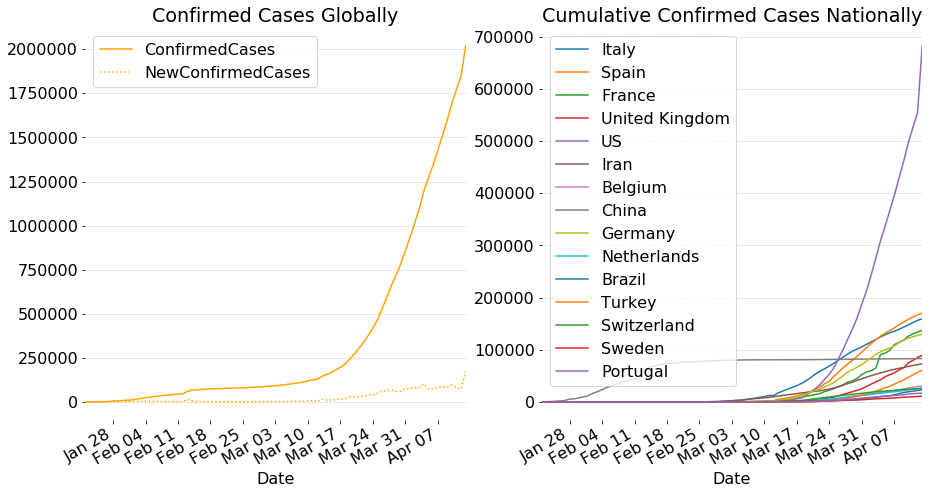

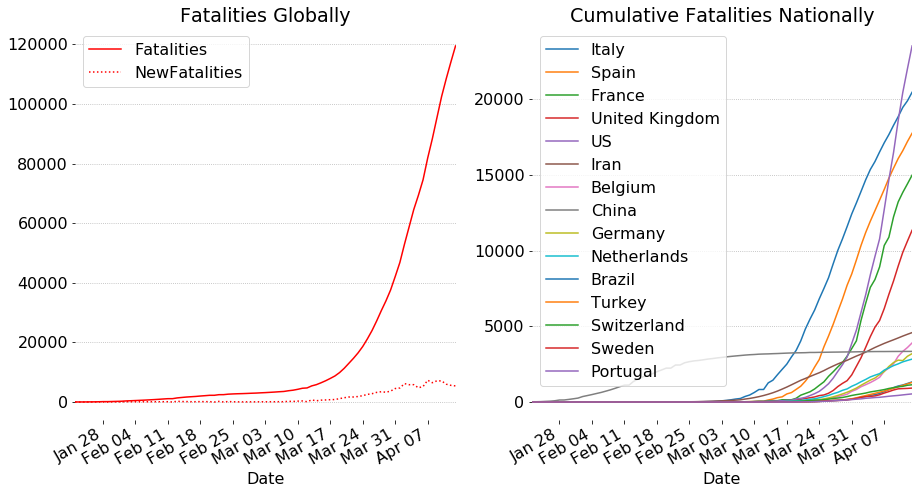

In [19]:
def reformat_time(reformat, ax):
    ax.xaxis.set_major_locator(dates.WeekdayLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b %d'))    
    if reformat: #reformat again if you wish
        date_list = train_data_by_date.reset_index()["Date"].tolist()
        x_ticks = [dt.datetime.strftime(t,'%Y-%m-%d') for t in date_list]
        x_ticks = [tick for i,tick in enumerate(x_ticks) if i%8==0 ]# split labels into same number of ticks as by pandas
        ax.set_xticklabels(x_ticks, rotation=90)
    # cosmetics
    ax.yaxis.grid(linestyle='dotted')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')

train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data_by_date = train_data.groupby(['Date'],as_index=True).agg({'ConfirmedCases': 'sum','Fatalities': 'sum', 
                                                                     'NewConfirmedCases':'sum', 'NewFatalities':'sum'})
#                                             MortalityRate':'mean'
num0 = train_data_by_date._get_numeric_data() 
num0[num0 < 0.0] = 0.0
#display(train_data_by_date.head())

## ======= Sort by countries with fatalities > 500 ========

train_data_by_country_max = train_data.groupby(['Country_Region'],as_index=True).agg({'ConfirmedCases': 'max', 'Fatalities': 'max'})
train_data_by_country_fatal = train_data_by_country_max[train_data_by_country_max['Fatalities']>500]
train_data_by_country_fatal = train_data_by_country_fatal.sort_values(by=['Fatalities'],ascending=False).reset_index()
display(train_data_by_country_fatal.head(20))

df_merge_by_country = pd.merge(train_data,train_data_by_country_fatal['Country_Region'],on=['Country_Region'],how='inner')
df_max_fatality_country = df_merge_by_country.groupby(['Date','Country_Region'],as_index=False).agg({'ConfirmedCases': 'sum',
                                                                                                     'Fatalities': 'sum',
                                                                                                     'NewConfirmedCases':'sum',
                                                                                                     'NewFatalities':'sum'
                                                                                                     })
#                                               MortalityRate':'mean'

num1 = df_max_fatality_country._get_numeric_data() 
num1[num1 < 0.0] = 0.0
df_max_fatality_country.set_index('Date',inplace=True)
#display(df_max_fatality_country.head(20))

countries = train_data_by_country_fatal['Country_Region'].unique()

plt.rcParams.update({'font.size': 16})

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(15, 8))
fig,(ax2,ax3) = plt.subplots(1,2,figsize=(15, 8))#,sharey=True)

train_data_by_date.ConfirmedCases.plot(ax=ax0, x_compat=True, title='Confirmed Cases Globally', legend='Confirmed Cases',
                                       color=discrete_col)#, logy=True)
reformat_time(0,ax0)
train_data_by_date.NewConfirmedCases.plot(ax=ax0, x_compat=True, linestyle='dotted', legend='New Confirmed Cases',
                                          color=discrete_col)#, logy=True)
reformat_time(0,ax0)

train_data_by_date.Fatalities.plot(ax=ax2, x_compat=True, title='Fatalities Globally', legend='Fatalities', color='r')
reformat_time(0,ax2)
train_data_by_date.NewFatalities.plot(ax=ax2, x_compat=True, linestyle='dotted', legend='Daily Deaths',color='r')#tell pandas not to use its own datetime format
reformat_time(0,ax2)

for country in countries:
    match = df_max_fatality_country.Country_Region==country
    df_fatality_by_country = df_max_fatality_country[match] 
    df_fatality_by_country.ConfirmedCases.plot(ax=ax1, x_compat=True, title='Cumulative Confirmed Cases Nationally')
    reformat_time(0,ax1)
    df_fatality_by_country.Fatalities.plot(ax=ax3, x_compat=True, title='Cumulative Fatalities Nationally')
    reformat_time(0,ax3)
    
ax1.legend(countries)
ax3.legend(countries)

 56%|█████▌    | 5/9 [00:00<00:00, 20.46it/s]





 Italy 
fatalities ==>, max:  35863.75 , slope: 0.07 , inflection point:  36.0 , r2 score: 0.93
confirmed ==> max:  239774.0 , slope: 0.07 , inflection point:  32.0 , r2 score: 0.95




 Spain 
fatalities ==>, max:  31073.0 , slope: 0.10 , inflection point:  37.5 , r2 score: 0.85
confirmed ==> max:  297678.25 , slope: 0.08 , inflection point:  37.0 , r2 score: 0.93




 France 
fatalities ==>, max:  29972.0 , slope: 0.10 , inflection point:  41.0 , r2 score: 0.77
confirmed ==> max:  310223.75 , slope: 0.08 , inflection point:  42.5 , r2 score: 0.90




 United Kingdom 
fatalities ==>, max:  25530.75 , slope: 0.14 , inflection point:  42.5 , r2 score: 0.40
confirmed ==> max:  201582.5 , slope: 0.08 , inflection point:  42.5 , r2 score: 0.74




 US 
fatalities ==>, max:  47054.0 , slope: 0.12 , inflection point:  41.5 , r2 score: 0.52
confirmed ==> max:  1194298.0 , slope: 0.12 , inflection point:  39.0 , r2 score: 0.37


 78%|███████▊  | 7/9 [00:00<00:00, 18.96it/s]





 Iran 
fatalities ==>, max:  6977.5 , slope: 0.07 , inflection point:  32.5 , r2 score: 0.96
confirmed ==> max:  110004.5 , slope: 0.07 , inflection point:  32.5 , r2 score: 0.92




 Belgium 
fatalities ==>, max:  6830.25 , slope: 0.14 , inflection point:  40.0 , r2 score: 0.39
confirmed ==> max:  61228.0 , slope: 0.08 , inflection point:  40.0 , r2 score: 0.83




 China 
fatalities ==>, max:  3395.0 , slope: 0.11 , inflection point:  20.0 , r2 score: 0.99
confirmed ==> max:  83263.0 , slope: 0.14 , inflection point:  15.0 , r2 score: 0.99




 Germany 
fatalities ==>, max:  5589.5 , slope: 0.14 , inflection point:  40.0 , r2 score: 0.71
confirmed ==> max:  227631.0 , slope: 0.08 , inflection point:  37.5 , r2 score: 0.95


100%|██████████| 9/9 [00:00<00:00, 15.61it/s]


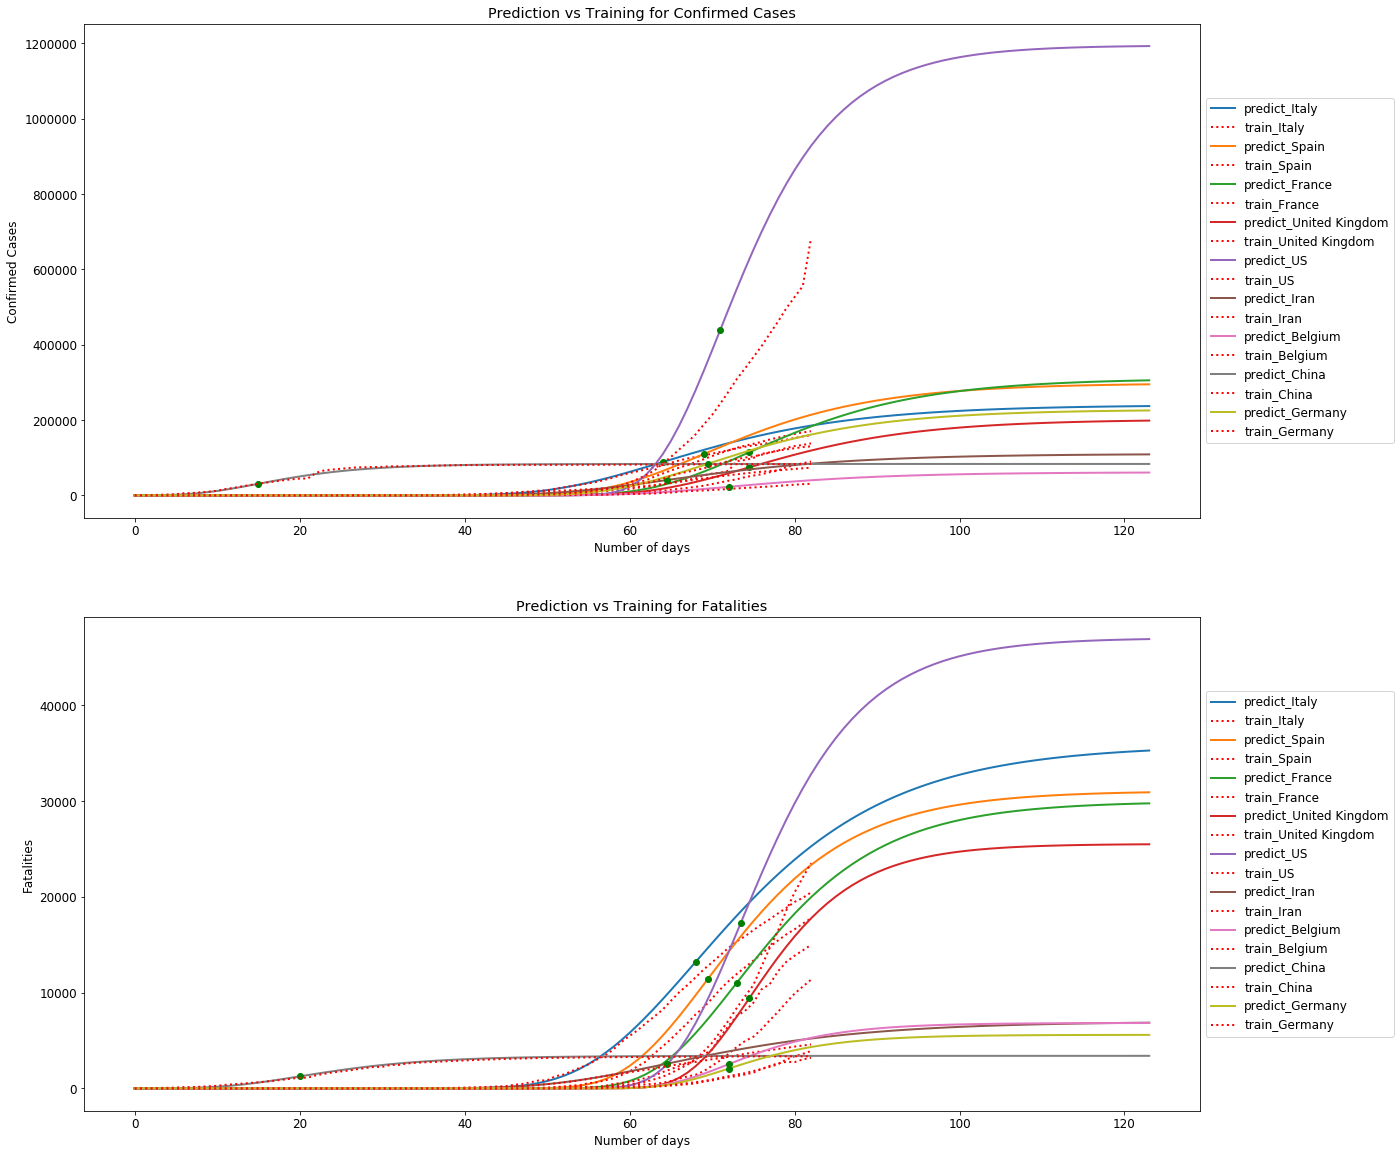

In [24]:
#only selected countries
countries= countries[0:9]
from tqdm import tqdm
from scipy.optimize.minpack import curve_fit
from sklearn.metrics import r2_score
from scipy.special import expit

def Gompertz(a, c, t, t0):    
    Q = a * np.exp(-np.exp(-c*(t-t0)))
    return Q
def Boltzman(a, c, t, t0):
    Q = a / (1 + np.exp(-c*(t-t0)))
    return Q

plt.rcParams.update({'font.size': 12})
fig,(ax0,ax1) = plt.subplots(2,1,figsize=(20, 20))
#countries_europe=['US', 'China', 'Iran', 'France', 'Italy', 'Spain', 'Germany', 'Belgium', 'Turkey', 'Netherlands', 'Switzerland', 'United Kingdom']
#countries_europe=['France']
for country in tqdm(countries): 
    #print('\n\n\n\n country ==>', country)
    df_country_train = df_max_fatality_country[df_max_fatality_country['Country_Region']==country] 
    df_country_test = test_data[test_data['Country_Region']==country]  
    if country != 'China':
        df_country_train = df_country_train.reset_index().loc[df_country_train.reset_index().Date>'2020-02-22'] #17
        n_days_sans_China =train_data.Date.nunique() - df_country_train.Date.nunique()        
    else:
        df_country_train = df_country_train.reset_index()
        n_days_sans_China = 0
        
    n_train_days =df_country_train.Date.nunique()    
    x_train = range(n_train_days)
    x_test  = range(n_train_days+n_test_days-overlap_days)#n_test_days+overlap_days)
    y_train_f = df_country_train['Fatalities']
    y_train_c = df_country_train['ConfirmedCases']    
    
    if country == 'China':
        lower = [100, 0.02, 0]
        upper = [2.0*max(y_train_f),0.2, 40]
    elif country == 'Iran':
        lower = [200, 0.00, 0]
        upper = [3.0*max(y_train_f),0.14, 65]
    elif country == 'Italy':
        lower = [100, 0.00, 0]
        upper = [3.5*max(y_train_f),0.15, 72]
    elif country == 'US':
        lower = [0, 0.02, 0]
        upper = [4.0*max(y_train_f),0.22, 83] 
    elif country == 'France':
        lower = [0, 0.02, 0]
        upper = [4.0*max(y_train_f),0.18, 82]    
    elif country == 'Spain':
        lower = [0, 0.02, 0]
        upper = [3.5*max(y_train_f),0.18, 75]
    elif country == 'Germany':
        lower = [0.0, 0.02, 0]
        upper = [3.5*max(y_train_f),0.25, 80] 
    elif country == 'Belgium':
        lower = [0.0, 0.02, 0]
        upper = [3.5*max(y_train_f),0.25, 80] 
    elif country == 'Turkey':
        lower = [0.0, 0.02, 0]
        upper = [4.0*max(y_train_f),0.25, 83]
    elif country == 'Netherlands':
        lower = [0.0, 0.02, 0]
        upper = [4.0*max(y_train_f),0.18, 80] 
    elif country == 'Switzerland':
        lower = [0.0, 0.02, 0]
        upper = [4.0*max(y_train_f),0.18, 80] 
    elif country == 'United Kingdom':
        lower = [0.0, 0.02, 0]
        upper = [4.5*max(y_train_f),0.25, 85]     
    else:
        lower = [0.0, 0.02, 0]
        upper = [4.5*max(y_train_f),0.25, 80]    
    
    popt_f, pcov_f = curve_fit(Gompertz, x_train, y_train_f, method='trf', bounds=(lower,upper))
    a_max, estimated_c, estimated_t0 = popt_f
    y_predict_f = Gompertz(a_max, estimated_c, x_test, estimated_t0)
    y_predict_f_at_t0 =  Gompertz(a_max, estimated_c, estimated_t0, estimated_t0)
    print("\n\n\n\n",country,'\nfatalities ==>, max: ',a_max, ', slope: %.2f'% estimated_c, ', inflection point: ', 
          estimated_t0, ', r2 score: %.2f'% r2_score(y_train_f[:], y_predict_f[0:n_train_days]))
   
    ###### Confirmed cases:    
        
    if country == 'China':
        lower_c = [100, 0.02, 0]
        upper_c = [2.0*max(y_train_c),0.25,30]
    elif country == 'Iran':
        lower_c = [100, 0.00, 0]
        upper_c = [3.0*max(y_train_c),0.15,65]
    elif country == 'Italy':
        lower_c = [1000, 0.00, 0]
        upper_c = [3.0*max(y_train_c),0.15, 64]
    elif country == 'US':
        lower_c = [0, 0.02, 0]
        upper_c = [3.5*max(y_train_c),0.23, 78] 
    elif country == 'France':
        lower_c = [10, 0.02, 0]
        upper_c = [4.5*max(y_train_c),0.15, 85]
    elif country == 'Spain':
        lower_c = [10, 0.02, 0]
        upper_c = [3.5*max(y_train_c),0.15, 74] 
    elif country == 'Germany':
        lower_c = [10, 0.02, 0]
        upper_c = [3.5*max(y_train_c),0.15, 75] 
    elif country == 'Belgium':
        lower_c = [100, 0.02, 0]
        upper_c = [4.0*max(y_train_c),0.15, 80]
    elif country == 'Turkey':
        lower_c = [100, 0.02, 0]
        upper_c = [4.0*max(y_train_c),0.25, 83] 
    elif country == 'Netherlands':
        lower_c = [100, 0.02, 0]
        upper_c = [4.0*max(y_train_c),0.14, 78] 
    elif country == 'Switzerland':
        lower_c = [100, 0.02, 0]
        upper_c = [3.5*max(y_train_c),0.14, 70]  
    elif country == 'United Kingdom':
        lower_c = [100, 0.02, 0]
        upper_c = [4.5*max(y_train_c),0.15, 85]    
    else:
        lower_c = [100, 0.02, 0]
        upper_c = [4.5*max(y_train_c),0.15, 80]
        
    
    popt_c, pcov_c = curve_fit(Gompertz, x_train, y_train_c, method='trf', bounds=(lower_c,upper_c))
    a_max_c, estimated_c_c, estimated_t0_c = popt_c
    y_predict_c = Gompertz(a_max_c, estimated_c_c, x_test, estimated_t0_c)
    y_predict_c_at_t0 =  Gompertz(a_max_c, estimated_c_c, estimated_t0_c, estimated_t0_c)
    print('confirmed ==> max: ',a_max_c, ', slope: %.2f'% estimated_c_c, ', inflection point: ', 
          estimated_t0_c, ', r2 score: %.2f'% r2_score(y_train_c[:], y_predict_c[0:n_train_days]))
    
    ## ===== Move the x-axis of trained and test datasets to allign with dates in China ======
    extend_days_test = [i+len(x_test) for i in range(n_days_sans_China)]
    x_test      = np.append(x_test, extend_days_test) 
    y_predict_c = np.pad(y_predict_c, (n_days_sans_China, 0), 'constant')
    y_predict_f = np.pad(y_predict_f, (n_days_sans_China, 0), 'constant')
    inflection_c = estimated_t0_c+n_days_sans_China

    extend_days_train = [i+len(x_train) for i in range(n_days_sans_China)]
    x_train     = np.append(x_train, extend_days_train)
    y_train_c   = np.pad(y_train_c, (n_days_sans_China, 0), 'constant')
    y_train_f   = np.pad(y_train_f, (n_days_sans_China, 0), 'constant')
    inflection_f = estimated_t0+n_days_sans_China
    
    ## ===== Plot =======
    ax0.plot(x_test, y_predict_c, linewidth=2, label='predict_'+country) 
    ax0.plot(inflection_c, y_predict_c_at_t0, marker='o', markersize=6, color='green')#, label='inflection')
    ax0.plot(x_train, y_train_c, linewidth=2, color='r', linestyle='dotted', label='train_'+country)   
    ax0.set_title("Prediction vs Training for Confirmed Cases")
    ax0.set_xlabel("Number of days")
    ax0.set_ylabel("Confirmed Cases")
    ax0.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    
    
    ax1.plot(x_test, y_predict_f, linewidth=2, label='predict_'+country) 
    ax1.plot(inflection_f, y_predict_f_at_t0, marker='o', markersize=6, color='green')
    ax1.plot(x_train, y_train_f, linewidth=2, color='r', linestyle='dotted', label='train_'+country)    
    ax1.set_title("Prediction vs Training for Fatalities")
    ax1.set_xlabel("Number of days")
    ax1.set_ylabel("Fatalities")
    ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

## 3.3 Results

As we can see, the results of the confirmed cases and fatalities by the two models are quite similar.
However, judging from the fitting precision of the models, the Logistic model is better than the Gompertz one. Excluding China, the Gompertz model shows the inflection point as 60-65 days since Jan 22nd shown by a green marker, meaning the time when new number of cases should start decreasing.

The predictions from Logistic model show that:
* New York's confirmed cases are expected to grow till 230.000 people infected. However, the forecasts, given the contagiousness of the virus and the population density, will certainly be worse in the future.
* For what concerns Italy, Spain and Germany, thanks to national responses to the virus (lockdowns), it seems that, in the near future, there will be a turning point into a stable direction.
* We cannot say the same for France and United Kingdom, where, due to a lack of an immediate national response, the contagion will not reach a stable point within the near future. 
* Iran's confirmed cases seems that will grow beyond 80.000 with a different epidemiological curve with respect to the other countries. 
* Hubei's forecasts show no changes about the total of confirmed cases, with a steady state of 70.000 and it is actually what is happening. However, in these days some return infections are reported.  
